<a href="https://colab.research.google.com/github/snel-repo/ComputationThruDynamicsBenchmark/blob/main/examples/notebooks/NeuroMatchNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<h1>
Project title
</h1>



__Content creators:__ Chris Versteeg

__Content reviewers:__ Chris Versteeg, Hannah Choi, Eva Dyer

__Content editors:__ Konstantinos Tsafatinos

__Production editors:__ Konstantinos Tsafatinos

__Our 2024 Sponsors:__ ?


# Characterizing computational similarity in task-trained recurrent neural networks

## Background

Researchers training artificial networks to perform tasks (e.g., image classification, motor control) have found that the activity in the artificial networks can resemble the activity of biological neurons from brain areas thought to perform similar tasks. Unfortunately, it is unclear whether a superficial similarity in neural activation necessarily translates to a conserved computational strategy. We need ways to assess how well different models are able to capture the computational principles, which will require datasets where the ground-truth computations are known and we can analyze similarity between artificial and natural systems. The aim of this project is to explore ways to measure alignment in dynamical systems, and to study different approaches to quantify the changes in representations across different tasks and across different architectures.


## Project Template

<img src="png/Template.png" width="1200"/>



# Data Exploration Notebook

In this notebook we are going to provide code to get you started on Q1-Q3 of this project! 

The basic outline looks like this:

- Section 1: Preparing the environment:
- Section 2: Overview of the available tasks:
- Section 3: Understanding the Three-Bit Flip-Flop task (3BFF):
- Section 4: Training a model to perform 3BFF:
- Section 5: Inspecting the performance of trained models:
    - Part 1: Visualizing latent activity
    - Part 2: Quantifying latent similarity with State R2:
    - Part 3: Visualizing Fixed-Point architectures:
- Section 6: Introduction to Random Target task:

## Importantly, we've put landmarks in the notebook to indicate: ##
### Interactive exercises

❓❓❓


### Cells which will a decent amount of time to run (>5 mins)

⏳⏳⏳

## Section 1: Preparing the environment

### IF USING COLAB:

Uncomment the lines of code below and run them in order. The top cell only needs to be run once, but the second cell (envStr) needs to be re-run if the Colab notebook crashes. These blocks install the needed dependencies and set up your environment.

⏳⏳⏳

### IF RUNNING LOCALLY (recommended if possible):

Follow the instructions [here](https://github.com/snel-repo/ComputationThruDynamicsBenchmark).

In [1]:
# ! git clone https://github.com/snel-repo/ComputationThruDynamicsBenchmark.git
# %cd ComputationThruDynamicsBenchmark
# ! pip install -e .
# RUN THIS CELL, THEN RESTART SESSION AS PROMPTED (BUTTON AT BOTTOM OF THIS CELL'S FINISHED OUTPUT). DO NOT NEED TO RUN AGAIN

In [2]:
# !pip uninstall -y torchaudio torchvision

In [3]:
# # GET BACK TO THE DIRECTORY AND CONFIGURE .env

# %cd /content/ComputationThruDynamicsBenchmark/

# envStr = """HOME_DIR=/content/ComputationThruDynamicsBenchmark/


# #Don't change these
# TRAIN_INPUT_FILE=train_input.h5\nEVAL_INPUT_FILE=eval_input.h5
# EVAL_TARGET_FILE=eval_target.h5
# """

# with open('.env','w') as f:
#   f.write(envStr)

## Section 2: Overview of the available tasks:

First, let's take a high-level look at the tasks that we are going to use to understand computation in artificial networks!

We'll start by loading in some packages.

In [4]:
# set the random seed for reproducibility
import random
import dotenv
import pathlib
import os
random.seed(2024)
dotenv.load_dotenv(override=True)
HOME_DIR = os.getenv("HOME_DIR")
print(HOME_DIR)

/home/csverst/Github/CtDBenchmark/



The Computation-Thru-Dynamics Benchmark has three distinct behavioral tasks.

These tasks are called:
1. Three-Bit Flip-Flop (3BFF) (see [Sussillo & Barak 2013](https://pubmed.ncbi.nlm.nih.gov/23272922/))
2. MultiTask (See [Driscoll et al. 2023](https://www.biorxiv.org/content/10.1101/2022.08.15.503870v1.full.pdf))
3. RandomTarget (See [Codol et al. 2023](https://elifesciences.org/reviewed-preprints/88591v2/reviews))

We chose these tasks because they represent a variety of task complexities. We have a pretty good understanding of how the simpler tasks operate (3BFF), but really are only starting to scratch the surface of more complex tasks (RandomTarget).


 
Specificially, in the Random Target task, the actions that the model takes can affect the future inputs, making it an important test case for being able to understand the dynamics of interacting systems!

<img src="png/TaskComplexity-01.png" width="600"/>

Each task (which we call a "task environment") follows a standardized format that allows alternative task environments to be incorporated without any changes to the training pipeline.

Here we'll take a walk through the two tasks in the project template (TBFF and RandomTarget) and inspect the behavior of networks trained on these environments.

## Section 3: Understanding the Three-Bit Flip-Flop task (3BFF):

We're going to start out with the task that launched a thousand Nature papers, the 3-Bit Flip-Flop. [Sussillo & Barak 2013](https://pubmed.ncbi.nlm.nih.gov/23272922/) used the three-bit flip-flop their seminal attempts to understand how dynamics can give rise to computation! 

The code snippet below intantiates an "TaskEnv" object, which contains the logic for the NBFF task.


❓❓❓

The default parameters are shown in ./interpretability/task_modeling/configs/env_task/NBFF.yaml, but try changing the parameters below to see how that affects trials generated from the environment. Note that this task is modular in the number of bits as well, so it provides an easy way to scale the dimensionality of a very simple dynamical system.

❓❓❓

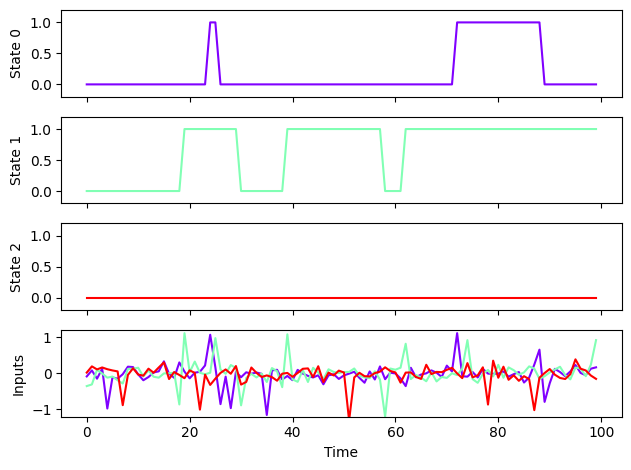

In [5]:
from ctd.task_modeling.task_env.task_env import NBitFlipFlop

n = 3 # The number of bits in the flip-flop (default: 3)
trial_length = 100 # The number of time steps in each trial (default: 500)
switch_prob = 0.03 # The probability of an input pulse (default: 0.015 pulses/channel / time step)
noise = 0.15 # The standard deviation of the Gaussian noise added to the input (default: 0.15)


# This line creates the NBitFlipFlop environment. See ctd.task_modeling.task_env.task_env.NBitFlipFlop for more information.
env_3bff = NBitFlipFlop(
    n = n, 
    n_timesteps=trial_length, 
    switch_prob=switch_prob, 
    noise=noise
    )

# Renders a random trial from the environment
env_3bff.render()

Above, we are plotting the inputs and outputs of the 3BFF task. One trial is 500 time steps, each with a 1% probability of getting an "up" or "down" pulse on each of its 3 input channels. When the task receives an "up" pulse, the state corresponding to that input channel moves from zero to one (if possible), and if a state at one receives a "down" pulse, it goes to zero. In this way, this system acts as 3 bits of memory, encoding 8 potential system states (2^3 states). We add noise to the inputs of the system so that it better reflects realistic computations that a neural circuit might perform.


### Try changing the parameters of your 3BFF environment to see how the behavior changes! ###

Another way to visualize this is to view the three states in 3D. Below you can see that the 8 potential states appear as the vertices of a cube. Each trial is plotted as column. 

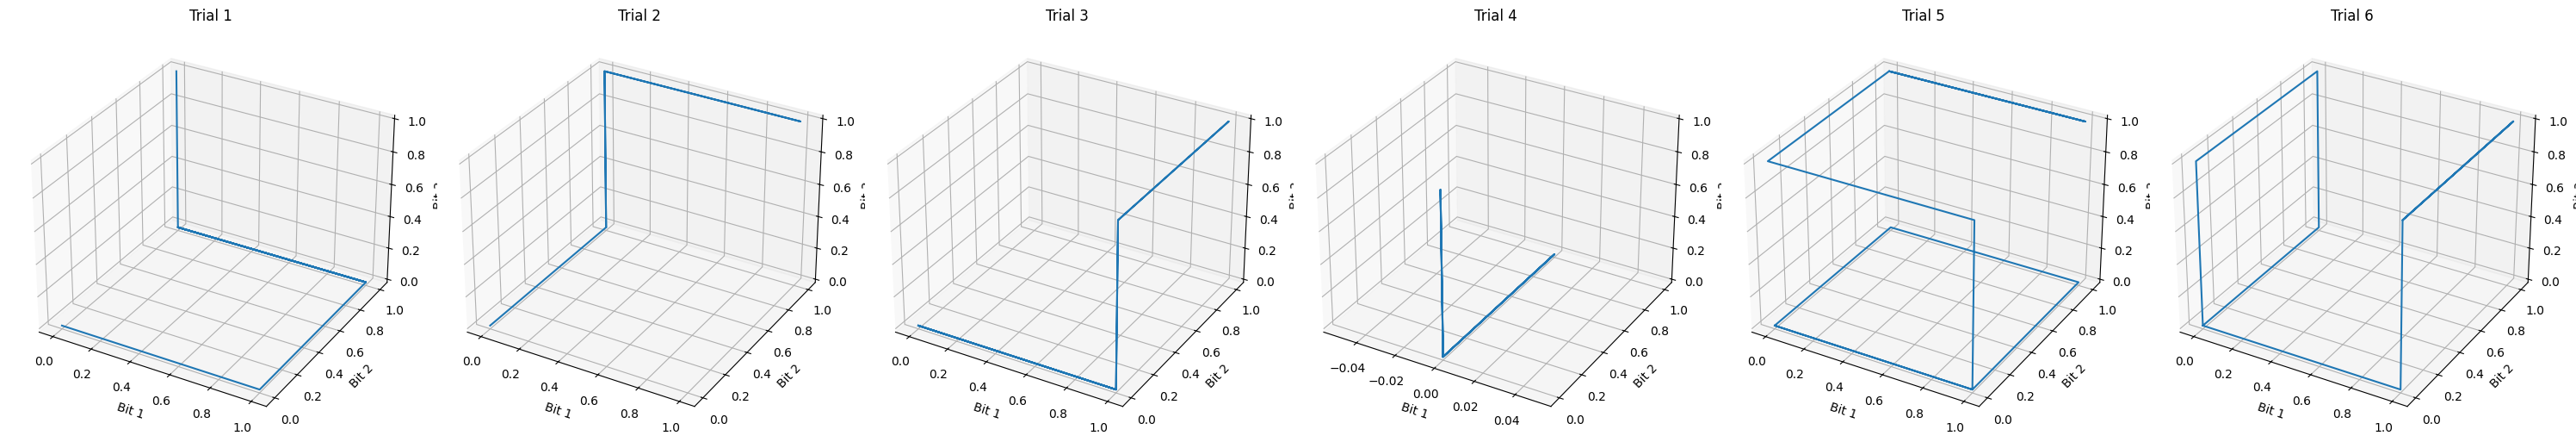

In [6]:
env_3bff.render_3d(n_trials=6)

Now that we can see the basic logic of the task, let's do a basic overview of what task-training is!

<img src="png/TTModelExample-01.png" width="600"/>

For task-training, we are simply training a model (e.g., an RNN) to produce a set of outputs given a set of inputs. This input/output relationship defines the task that the model is performing. In the case of 3BFF, an input pulse should cause the model's output to change in a way that reflects the switching of a bit. 

### 3BFF Training Objective:
3BFF models are trained to minimize the MSE between the desired output and the output of the model, with some other components that pressure the solution to be smooth. If you're interested in the specifics, the implementation of the loss function can be found as the NBFFLoss object in ctd/task_modeling/task_env/loss_func.py.



## Section 4: Training a model to perform 3BFF:

For this tutorial, we are using PyTorch Lightning to abstract much of the engineering away, allowing you to focus your full attention on the scientific questions you want to tackle!

This segment takes a few minutes to train, so I'd recommend planning your runs accordingly!

⏳⏳⏳

The cell below will create a recurrent neural network (RNN) model and use the 3BFF environment to generate samples that the model will be trained on!

Unfortunately, it generates a lot of output, so if you don't care to see the model progress, set enable_progress_bar to False below.

In [7]:
from ctd.task_modeling.model.rnn import GRU_RNN
from ctd.task_modeling.datamodule.task_datamodule import TaskDataModule
from ctd.task_modeling.task_wrapper.task_wrapper import TaskTrainedWrapper
from pytorch_lightning import Trainer

enable_progress_bar = False

# Step 1: Instantiate the model
rnn = GRU_RNN(latent_size = 128) # Look in ctd/task_modeling/models for alternative choices!

# Step 2: Instantiate the task environment
task_env = env_3bff

# Step 3: Instantiate the task datamodule
task_datamodule = TaskDataModule(task_env, n_samples = 1000, batch_size = 1000)

# Step 4: Instantiate the task wrapper
task_wrapper = TaskTrainedWrapper(learning_rate=1e-3, weight_decay = 1e-8)

# Step 5: Initialize the model with the input and output sizes (3 inputs, 3 outputs, in this case)
rnn.init_model(
    input_size = task_env.observation_space.shape[0], 
    output_size = task_env.action_space.shape[0]
    )

# Step 6:  Set the environment and model in the task wrapper
task_wrapper.set_environment(task_env)
task_wrapper.set_model(rnn)

# Step 7: Define the PyTorch Lightning Trainer object
trainer = Trainer(max_epochs=500, enable_progress_bar=enable_progress_bar)

# Step 8: Fit the model
trainer.fit(task_wrapper, task_datamodule)

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name  | Type    | Params
----------------------------------
0 | model | GRU_RNN | 51.6 K
----------------------------------
51.6 K    Trainable params
0     

Now, we use pickle to save the trained model and datamodule for use in future analyses!

❓❓❓

### Once you get this model trained, feel try to try changing the hyperparameters to see if you can get the model to train faster! ###

❓❓❓

In [8]:
import pickle
# save model as .pkl
save_dir = pathlib.Path(HOME_DIR) / "models_GRU_128"
save_dir.mkdir(exist_ok=True)
with open(save_dir / "model.pkl", "wb") as f:
    pickle.dump(task_wrapper, f)

# save datamodule as .pkl
with open(save_dir / "datamodule_sim.pkl", "wb") as f:
    pickle.dump(task_datamodule, f)

So that we can start comparing our models, we're going to train a second GRU_RNN to perform the 3BFF task, except this time, we'll use an alternative model called a Neural ODE! 

Notice that we're using the same datamodule as for the first model, meaning that we can directly compare the two models trial-by-trial.

Again, this will take a few minutes to train!

<img src="png/Hourglass.png" width="100"/> 


In [9]:
from ctd.task_modeling.model.node import NODE
enable_progress_bar = False
rnn = NODE(latent_size = 3, num_layers = 3, layer_hidden_size=64) # Look in ctd/task_modeling/models for alternative choices!
task_wrapper = TaskTrainedWrapper(learning_rate=1e-3, weight_decay = 1e-10)
rnn.init_model(
    input_size = task_env.observation_space.shape[0], 
    output_size = task_env.action_space.shape[0]
    )
task_wrapper.set_environment(task_env)
task_wrapper.set_model(rnn)
trainer = Trainer(max_epochs=500, enable_progress_bar=enable_progress_bar)

trainer.fit(task_wrapper, task_datamodule)

save_dir = pathlib.Path(HOME_DIR) / "models_NODE_3"
save_dir.mkdir(exist_ok=True)
with open(save_dir / "model.pkl", "wb") as f:
    pickle.dump(task_wrapper, f)

# save datamodule as .pkl
with open(save_dir / "datamodule_sim.pkl", "wb") as f:
    pickle.dump(task_datamodule, f)

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name  | Type | Params
-------------------------------
0 | model | NODE | 4.8 K 
-------------------------------
4.8 K     Trainable params
0         Non-trainable params
4.8 K     Total params
0.019     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=500` reached.


## Section 5: Inspecting the performance of trained models:

Now that the models have been trained, let's see if we can determine how similar their computational strategies are to each other!

To make your life easier, we've provided an "analysis" object that abstracts away much of the data handling, allowing you to work more easily with the data from the models.

The analysis object also offers visualization tools that can help to see how well the trained model learned to perform the task!

For example, plot_trial_io is a function that plots (for a specified number of trials):
- Latent activity
- Controlled output
- Target output
- Noisy inputs to model

❓❓❓

### Try changing trials that are plotted. Do the models capture all of the states equally well? ###

❓❓❓

### Part 1: Visualizing latent activity:


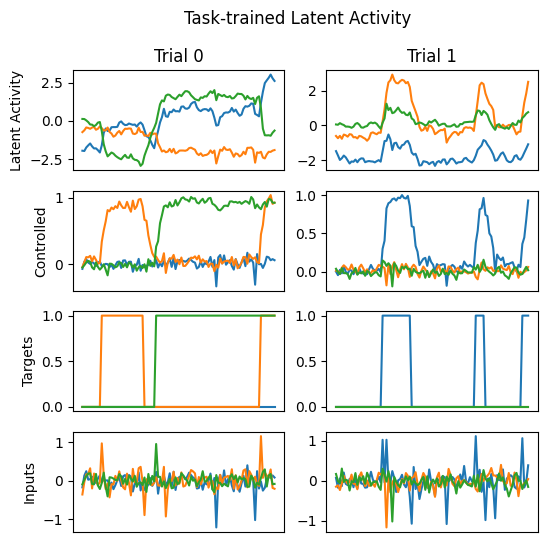

In [10]:
from ctd.comparison.analysis.tt.tt import Analysis_TT

fpath_GRU_128 = HOME_DIR + "models_GRU_128/"
# Create the analysis object:
analysis_GRU_128 = Analysis_TT(
    run_name = "GRU_128_3bff", 
    filepath = fpath_GRU_128)

analysis_GRU_128.plot_trial_io(num_trials = 2)


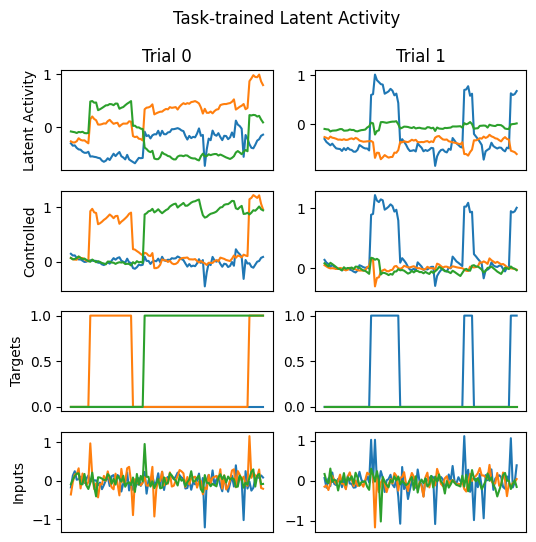

In [11]:

fpath_NODE = HOME_DIR + "models_NODE_3/"
# Create the analysis object:
analysis_NODE = Analysis_TT(
    run_name = "NODE_3_3bff", 
    filepath = fpath_NODE)

analysis_NODE.plot_trial_io(num_trials = 2)

There are also useful data visualization functions, such as visualizing a scree plot of the latent activity.

A scree plot shows the % of variance in the highest principle component dimensions. From this plot we can see that the GRU has the majority of its variance in the first 3 PCs, but there remains significant variance in the lower PCs!

array([0.3746551 , 0.27120809, 0.2165594 , 0.0225437 , 0.02141094,
       0.01859307, 0.00982641, 0.00732599, 0.00621966, 0.0051203 ])

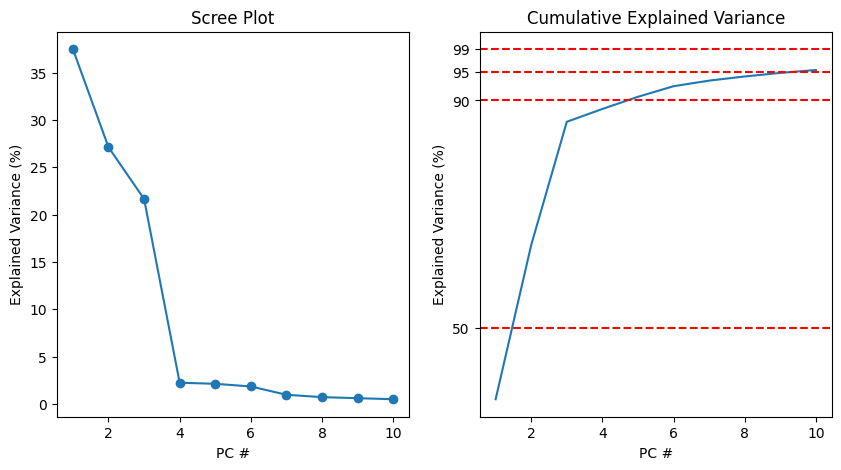

In [12]:
analysis_GRU_128.plot_scree()

Importantly, the analysis object also provides functions that give access to the raw latent activity, predicted outputs, etc. of the trained models! All of these functions accept a "phase" variable that designates whether to return the training and/or validation datasets. 
These functions are:
- get_latents(): Returns latent activity of the trained model
- get_inputs(): Returns the inputs to the model (for 3BFF, the input pulses)
- get_model_output(): Returns a dict that contains all model outputs:
  - controlled - the variable that the model is controlling
  - latents - the latent activity
  - actions - the output from the model (for RandomTarget only)
  - states - the state of the environment (for RandomTarget only)
  - joints - Joint angles (for RandomTarget only)

In [13]:
print(f"All data shape: {analysis_GRU_128.get_latents().shape}")
print(f"Train data shape: {analysis_GRU_128.get_latents(phase = 'train').shape}")
print(f"Validation data shape: {analysis_GRU_128.get_latents(phase = 'val').shape}")

All data shape: torch.Size([1000, 100, 128])
Train data shape: torch.Size([800, 100, 128])
Validation data shape: torch.Size([200, 100, 128])


## Part 2: Using affine transformations to compare latent activity

Now that we have the latent activity for the 64D and the 128D GRU models trained on 3BFf, we can investigate how similar their latent activity is.

One problem: The models may be arbitrarily rotated, scaled, and translated relative to each other! 

This means that we need to find the best "fit" between the two models that doesn't fail when they are equivalent under an "affine" transformation (meaning a linear transformation and/or translation).

Luckily, we have a tool that can solve this problem for us! Linear regression.

In this code, we are:

1. Getting the latent activity from each model
2. Performing PCA on the latent activity (to get the dimensions ordered by their variance)
3. Fit a linear regression from one set of latent activity to the other.

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

source = analysis_GRU_128
target = analysis_NODE

# Get the latent activity from the validation phase for each model:
latents_source = source.get_latents(phase='val').detach().numpy()
latents_targ = target.get_latents(phase='val').detach().numpy()

n_trials_s, n_timesteps_s, n_latent_s = latents_source.shape
n_trials_t, n_timesteps_t, n_latent_t = latents_targ.shape

print(f"Latent shape for source model: {latents_source.shape}"
      f"\nLatent shape for target model: {latents_targ.shape}")

Latent shape for source model: (200, 100, 128)
Latent shape for target model: (200, 100, 3)


In [15]:

# Perform PCA on both latent spaces to find axes of highest variance
pca_source = PCA()
pca_targ = PCA()

lats_source_pca = pca_source.fit_transform(latents_source.reshape(-1, n_latent_s)).reshape((n_trials_s, n_timesteps_s, -1))
lats_targ_pca = pca_targ.fit_transform(latents_targ.reshape(-1, n_latent_t)).reshape((n_trials_t, n_timesteps_t, -1))

# Fit a linear regression model to predict the target latents from the source latents
reg = LinearRegression().fit(lats_source_pca.reshape(-1, n_latent_s), lats_targ_pca.reshape(-1, n_latent_t))

# Get the R2 of the model fit
preds = reg.predict(lats_source_pca.reshape(-1, n_latent_s))
r2s = r2_score(lats_targ_pca.reshape((-1, n_latent_t)), preds,  multioutput = "raw_values")
r2_var = r2_score(lats_targ_pca.reshape((-1, n_latent_t)), preds, multioutput = "variance_weighted")
print(f"R2 of linear regression fit: {r2s}")
print(f"Variance-weighted R2 of linear regression fit: {r2_var}")

R2 of linear regression fit: [0.92828523 0.88163686 0.88808817]
Variance-weighted R2 of linear regression fit: 0.9070879933245514


So the variance weighted R2 from the source to the target is ~0.93.

Importantly, we had to pick a "direction" to compute this R2 value. What happens if we switch the source and targets?

❓❓❓

**Try reversing the direction (the source and targets) and see how well the model fits!**

❓❓❓

One final tool that is provided to you is the comparison object, which does many of these direct comparisons within the object itself. Here is one example visualization that shows how similar the latent activity of two example trials are for these two models! 

This function has the affine transformation "built-in" so you don't this shows what your R2 value above looks like in the first 3 PCs!

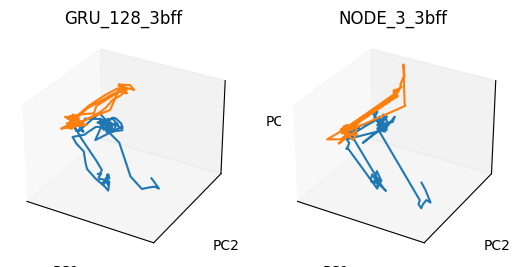

In [16]:
from ctd.comparison.comparison import Comparison
comp = Comparison()
comp.load_analysis(analysis_GRU_128, reference_analysis=True)
comp.load_analysis(analysis_NODE)
comp.plot_trials_3d_reference(num_trials=2)

## Part 3: Fixed-point finding



Finally, we can use fixed-point finding to inspect the linearized dynamics of the trained model.

### What are fixed-points? ###
Fixed points are points in the dynamics for which the flow field is zero, meaning that points at that location do not move.

The fixed point structure for the 3BFF task was first shown in the original [Sussillo and Barack paper](https://ccn.johndmurray.org/ccn_2013/materials/pdf/mante/sussillo_2013.pdf).

<img src="png/SussilloBarack.png" width="400"/> 


We can see that the fixed-points are at the vertices of the cube above, drawing the activity towards them and keeping it there until an input pushes it out!

We use a modified version of a fixed point finder released by [Golub et al. 2018](https://github.com/mattgolub/fixed-point-finder) to search the flow field for these zero points.

❓❓❓

**Try changing some of these parameters:** 
- How quickly are the fixed-points found in the model?
- How many initializations are needed to find the fixed points?
- Do the stability properties tell us anything about the underlying computation?

❓❓❓

Importantly from [Driscol et al. 2022](https://www.biorxiv.org/content/10.1101/2022.08.15.503870v1.full.pdf), we know that changes in the inputs can have large effects on the fixed point architecture, so we're going to set the inputs to zero in this optimization.


Iteration 500/20000
q = 6.96E-03 +/- 2.52E-02
dq = 3.43E-05 +/- 1.23E-04

Iteration 1000/20000
q = 1.33E-03 +/- 4.89E-03
dq = 2.89E-06 +/- 1.12E-05

Iteration 1500/20000
q = 5.85E-04 +/- 2.21E-03
dq = 7.52E-07 +/- 2.83E-06

Iteration 2000/20000
q = 3.37E-04 +/- 1.27E-03
dq = 3.28E-07 +/- 1.29E-06

Iteration 2500/20000
q = 2.16E-04 +/- 8.16E-04
dq = 1.75E-07 +/- 6.69E-07

Iteration 3000/20000
q = 1.49E-04 +/- 5.72E-04
dq = 1.05E-07 +/- 3.83E-07

Iteration 3500/20000
q = 1.06E-04 +/- 4.22E-04
dq = 6.96E-08 +/- 2.57E-07

Iteration 4000/20000
q = 7.70E-05 +/- 3.19E-04
dq = 4.78E-08 +/- 1.81E-07

Iteration 4500/20000
q = 5.70E-05 +/- 2.45E-04
dq = 3.33E-08 +/- 1.33E-07

Iteration 5000/20000
q = 4.28E-05 +/- 1.89E-04
dq = 2.42E-08 +/- 1.04E-07

Iteration 5500/20000
q = 3.23E-05 +/- 1.45E-04
dq = 1.85E-08 +/- 8.60E-08

Iteration 6000/20000
q = 2.41E-05 +/- 1.08E-04
dq = 1.47E-08 +/- 7.32E-08

Iteration 6500/20000
q = 1.77E-05 +/- 7.98E-05
dq = 1.16E-08 +/- 5.74E-08

Iteration 7000/20000
q = 

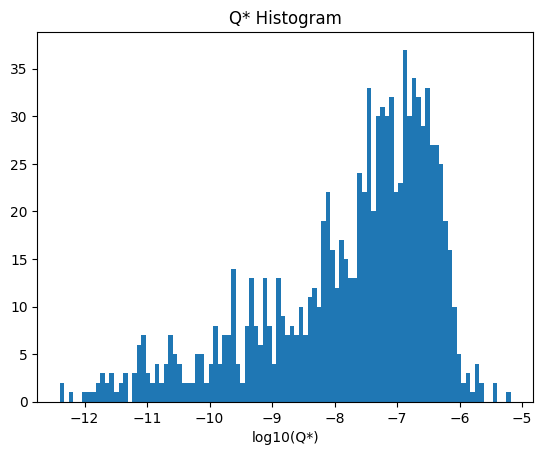

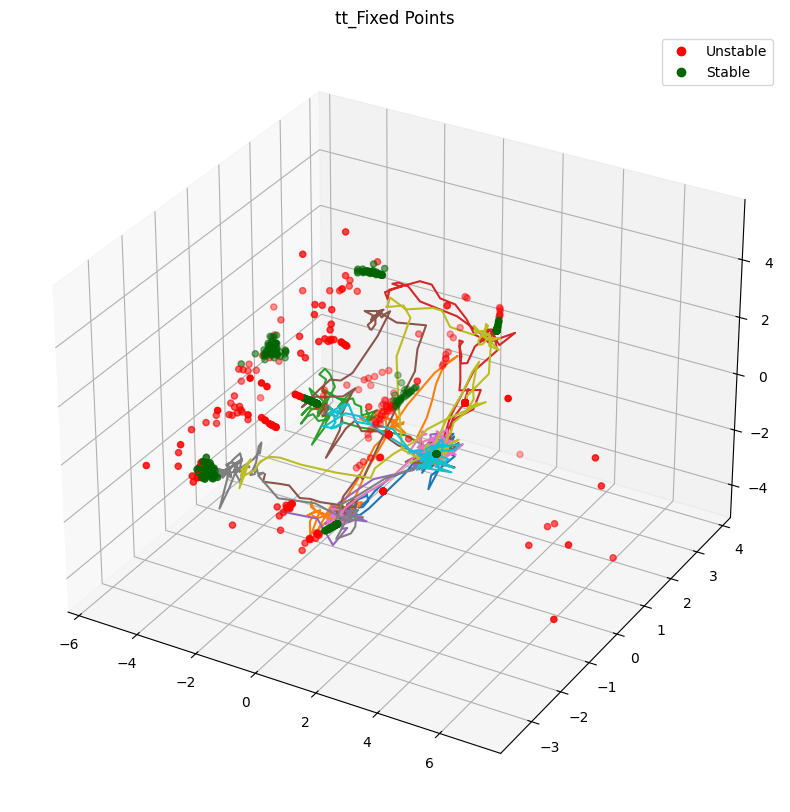

In [17]:
import torch
# Add documentation on what each of these do
fps = analysis_GRU_128.plot_fps(
inputs= torch.zeros(3),
n_inits=1024,
learning_rate=1e-3,
noise_scale=0.0,
max_iters=20000,
seed=0,
compute_jacobians=True,
q_thresh=1e-5,
)

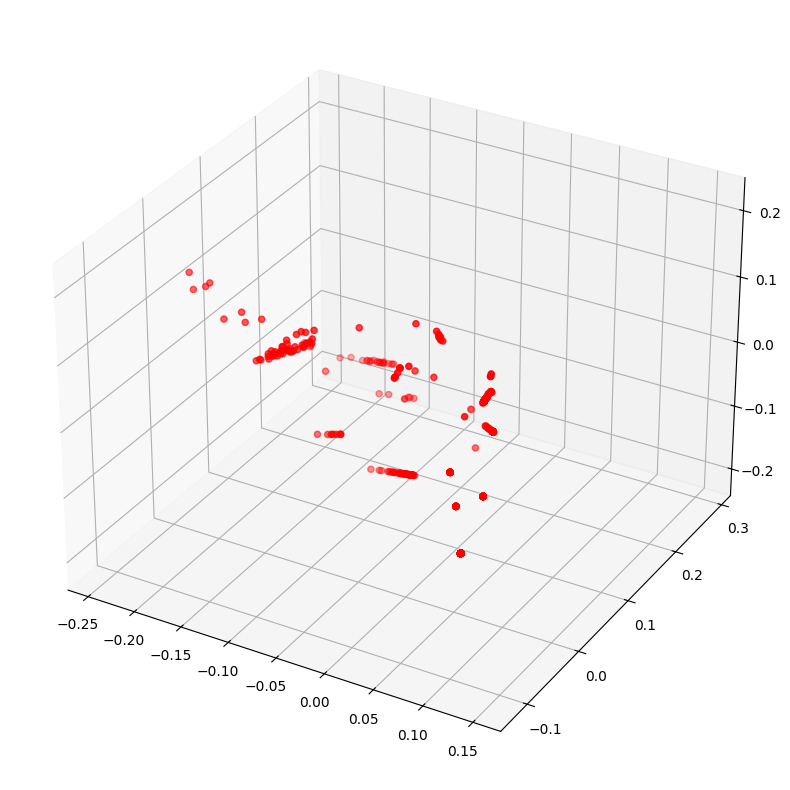

In [18]:
import matplotlib.pyplot as plt
q_thesh = 1e-7
q_vals = fps.qstar
x_star = fps.xstar[q_vals < q_thesh]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_star[:, 0], x_star[:, 1], x_star[:, 2], c='r', marker='o')

❓❓❓

What can you find out about the FPs of the trained models? Can you modify the FP finding hps to get more interpretable results?

What can we learn about the computational solution built in this 3BFF network from these fixed-point architectures?

❓❓❓

## Section 6: Introducing the Random Target task:

Now that we've developed intuition on a simple, well understood task, let's move up the ladder of complexity!

The second task is a random-target reaching task performed by an RNN controlling a 2-joint musculoskeletal model of an arm actuated by 6 Mujoco muscles. This environment was built using MotorNet, a package developed by [Oli Codol et al.](https://github.com/OlivierCodol/MotorNet) that provides environments for training RNNs to control biomechanical models!

Here is a short clip of what this task looks like when performed by a well-trained model:

<img src="png/FinalGif.gif" width="300"/>


Behaviorally, the task has the following structure:
1. A random initial hand position is sampled from a range of reachable locations; the model is instructed to maintain that hand position.
2. A random target position is chosen from the range of reachable locations and fed to the model.
3. After a random delay period, a go-cue is fed to the model, which prompts the model to generate muscle activations that drive the hand to the target location.
4. On 20% of trials, the go-cue is never supplied ("catch" trials)
5. On 50% of trials, a randomly directed bump perturbation (5-10 N, 150-300 ms duration) is applied to the hand.
    - 50% of these bumps occur in a small window after the go-cue
    - 50% of these bumps occur at a random time in the trial

The model is trained to:
1. Minimize the MSE between the hand position and the desired hand position
2. Minimize the squared muscle activation

with each loss term being weighted by a scalar.


In [19]:
from ctd.task_modeling.task_env.task_env import RandomTarget
from motornet.effector import RigidTendonArm26
from motornet.muscle import MujocoHillMuscle
# Create the analysis object:
rt_task_env = RandomTarget(effector = RigidTendonArm26(muscle = MujocoHillMuscle()))

⏳⏳⏳

Now to train the model! We use the same procedure as the 3BFF above; this model will take a bit longer to train however, and you will want to turn off the GPUs (if you have them). Because of the serial nature of this task, the parallelization allowed by GPUs doesn't help speed up our training!

⏳⏳⏳

In [20]:
from ctd.task_modeling.model.rnn import GRU_RNN
from ctd.task_modeling.datamodule.task_datamodule import TaskDataModule
from ctd.task_modeling.task_wrapper.task_wrapper import TaskTrainedWrapper
from pytorch_lightning import Trainer

# Step 1: Instantiate the model
rnn = GRU_RNN(latent_size = 128) # Look in ctd/task_modeling/models for alternative choices!

# Step 2: Instantiate the task environment
task_env = rt_task_env

# Step 3: Instantiate the task datamodule
task_datamodule = TaskDataModule(task_env, n_samples = 1000, batch_size = 256)

# Step 4: Instantiate the task wrapper
task_wrapper = TaskTrainedWrapper(learning_rate=1e-3, weight_decay = 1e-8)

# Step 5: Initialize the model with the input and output sizes
rnn.init_model(
    input_size = task_env.observation_space.shape[0] + task_env.context_inputs.shape[0], 
    output_size = task_env.action_space.shape[0]
    )

# Step 6:  Set the environment and model in the task wrapper
task_wrapper.set_environment(task_env)
task_wrapper.set_model(rnn)

# Step 7: Define the PyTorch Lightning Trainer object
trainer = Trainer(accelerator= "cpu",max_epochs=500,enable_progress_bar=True)

# Step 8: Fit the model
trainer.fit(task_wrapper, task_datamodule)

/home/csverst/miniconda3/envs/build5/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'data_env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['data_env'])`.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/csverst/miniconda3/envs/build5/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name     | Type         | Params
------------------------------------------
0 | task_env | RandomTarget | 84    
1 | model    | GRU_RNN      | 57.4 K
------------------------------------------
57.4 K    Trainable params
84        Non-trainable params
57.4 K    Total params
0.230     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/csverst/miniconda3/envs/build5/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


Importantly, this task is distinct from the previous two tasks because the outputs of the model affect the subsequent inputs!

<img src="png/MotorNet Illustration-01.png" width="800"/>


Visualizing the latent dynamics of models trained on MotorNet tasks, we can see that there are complex features in the state space, but we'll leave that to you to figure out what they mean!

<img src="png/MotorNetGif.gif" width="300"/>



In the later questions, we will ask you to modify the environments in MotorNet to test how well your models can generalize to new tasks!


# Conclusion:

That's it!

To recap, in this tutorial we learned:
1. The basics of two tasks, the Three-Bit Flip-Flop and the Random Target task.
2. How to train recurrent neural network models on these tasks
3. Methods of visualizng and quantifying differences between these task-trained models.

As you begin to extend beyond this tutorial, you will likely need to make your own environments, or modify existing environments to test the ability of models to generalize. We've tried to document the code-base to make this as easy as possible, but feel free to reach out if you have any questions!